# Loading dataset

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')
warnings.filterwarnings("ignore", category=UserWarning, module="hmmlearn.hmm")

### Loading data

In [120]:
data = pd.read_csv('/content/drive/MyDrive/ML4crypt2024/TrainingData.csv')
data

,BID,Bitstream,class
0,0,1000111010111101101100110111001111001000101111...,1
1,1,1101111100101011111111101101010001110110000010...,1
2,2,0011001010001010100100011101000111110100101111...,0
3,3,1101010110000110100001001100111101000000110001...,1
4,4,1010111100001001000101010010111010011101001100...,1
...,...,...,...
1995,1995,1110110011110100001111101111010110011000001110...,0
1996,1996,0100010100011110101110000110100101100000011001...,1
1997,1997,1100001010100011010001110001010010101010101100...,0
1998,1998,0011110000001110101101111110110100010010100011...,1


# Checking Bit Count Column wise for both classes

In [121]:
bitstream_df = data['Bitstream'].apply(lambda x: pd.Series(list(x))).astype(int)

class_0_df = bitstream_df[data['class'] == 0]
class_1_df = bitstream_df[data['class'] == 1]

# Calculate percentage of 1s and 0s for each bit position for class 0
bit_percentages_class_0 = pd.DataFrame({
    'Position': range(1, class_0_df.shape[1] + 1),
    'Percent_1': (class_0_df.sum(axis=0) / len(class_0_df)) * 100,
    'Percent_0': (1 - class_0_df.mean(axis=0)) * 100
})

# Calculate percentage of 1s and 0s for each bit position for class 1
bit_percentages_class_1 = pd.DataFrame({
    'Position': range(1, class_1_df.shape[1] + 1),
    'Percent_1': (class_1_df.sum(axis=0) / len(class_1_df)) * 100,
    'Percent_0': (1 - class_1_df.mean(axis=0)) * 100
})

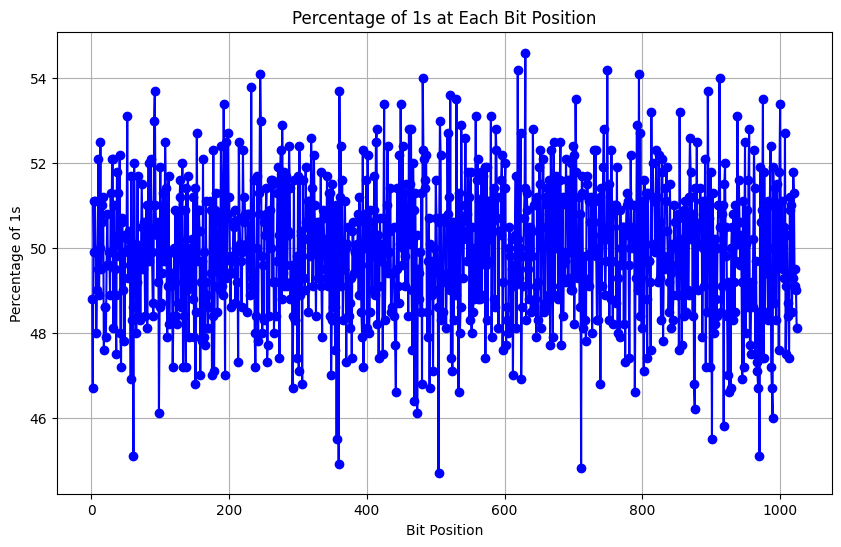

In [122]:

plt.figure(figsize=(10, 6))
plt.plot(bit_percentages_class_0['Position'], bit_percentages_class_0['Percent_0'], marker='o', color='b', linestyle='-')
plt.xlabel('Bit Position')
plt.ylabel('Percentage of 1s')
plt.title('Percentage of 1s at Each Bit Position')
plt.grid()
plt.show()

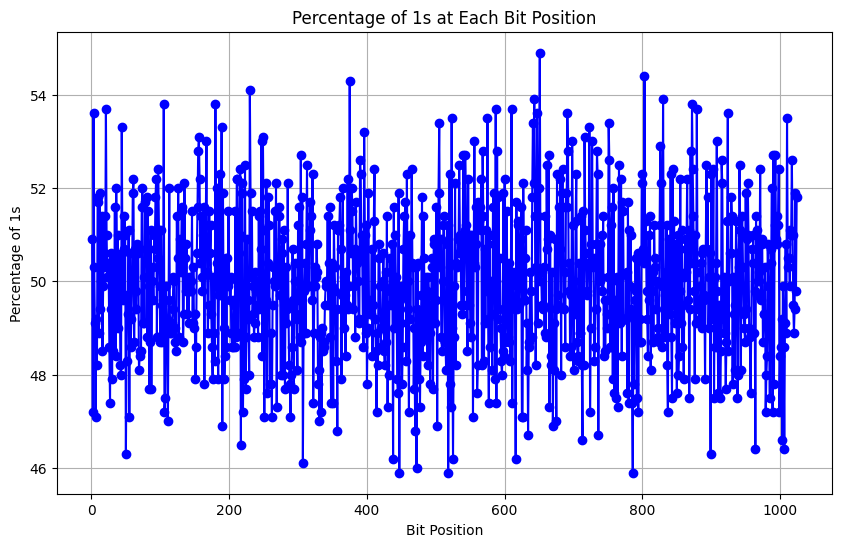

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(bit_percentages_class_1['Position'], bit_percentages_class_1['Percent_0'], marker='o', color='b', linestyle='-')
plt.xlabel('Bit Position')
plt.ylabel('Percentage of 1s')
plt.title('Percentage of 1s at Each Bit Position')
plt.grid()
plt.show()

# Visualization by PCA

In [124]:
from sklearn.decomposition import PCA
import seaborn as sns

In [125]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(bitstream_df)
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['y'] = data['class']

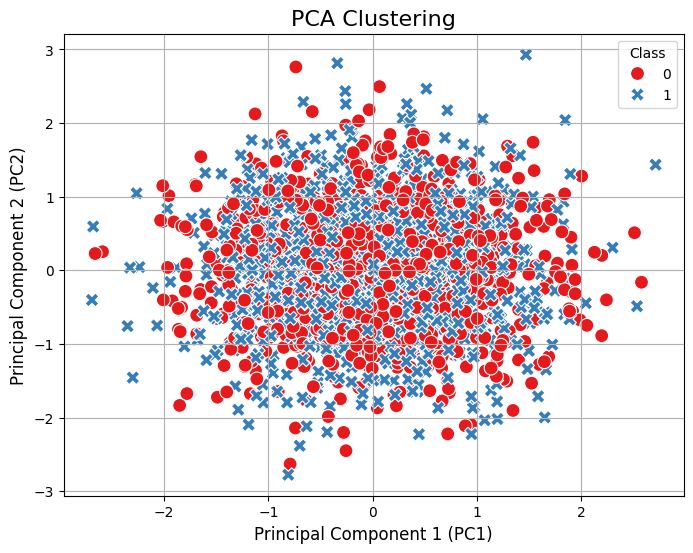

In [126]:
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['y'] = data['class']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='y', data=pca_df, palette="Set1", s=100, style="y")

plt.title('PCA Clustering', fontsize=16)
plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
plt.grid(True)
plt.legend(title='Class', loc='upper right')
plt.show()


No separation seen in PCA

# Model Initialization

In [144]:
def ML_models(X):
  y = data['class'].values

  skf = StratifiedKFold(n_splits=5)

  lgbm_model = LGBMClassifier(verbose=-1)

  lgbm_cv_scores = cross_val_score(lgbm_model, X, y, cv=skf)

  print(f"LGBM Cross-validation scores: {lgbm_cv_scores}")
  print(f"Mean LGBM cross-validation score: {lgbm_cv_scores.mean() * 100:.2f}%")
  print('-----------------------')


  gnb_model = GaussianNB(
  )

  gnb_cv_scores = cross_val_score(gnb_model, X, y, cv=skf)

  print(f"GaussianNB Cross-validation scores: {gnb_cv_scores}")
  print(f"Mean GaussianNB cross-validation score: {gnb_cv_scores.mean() * 100:.2f}%")
  print('-------------------------')

  rf_model = RandomForestClassifier()

  rf_cv_scores = cross_val_score(rf_model, X, y, cv=skf)

  print(f"Random Forest Cross-validation scores: {rf_cv_scores}")
  print(f"Mean Random Forest cross-validation score: {rf_cv_scores.mean() * 100:.2f}%")

def DL_model(X):
  def ANN_model(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Flatten(input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=128,
    )

    loss, accuracy = model.evaluate(X_test, y_test)
    return accuracy

  # Training with cross-validation approach
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  cv_accuracies = []

  for train_index, test_index in kf.split(X):
      X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
      y_train, y_test = y[train_index], y[test_index]

      accuracy_ann = ANN_model(X_train, y_train, X_test, y_test)

      cv_accuracies.append(accuracy_ann)
  return cv_accuracies, np.mean(cv_accuracies)


## Cross validation in required becuase data sample quantity is very low compared with bitstring length.

# Results using LGBM, GaussianNB and RandomForest model with Strafied Cross-validation


In [167]:
ML_models(bitstream_df)

LGBM Cross-validation scores: [0.5475 0.46   0.4925 0.4875 0.525 ]
Mean LGBM cross-validation score: 50.25%
-----------------------
GaussianNB Cross-validation scores: [0.5425 0.475  0.54   0.5275 0.5075]
Mean GaussianNB cross-validation score: 51.85%
-------------------------
Random Forest Cross-validation scores: [0.5225 0.4775 0.4575 0.4825 0.515 ]
Mean Random Forest cross-validation score: 49.10%


# ANN model with Cross-Validation

In [ ]:
accuracies, mean_accuracy = DL_model(bitstream_df)

In [169]:
print('ANN model cross validation accuracies', accuracies)
print('ANN model mean accuracy', np.mean(accuracies))

ANN model cross validation accuracies [0.5350000262260437, 0.48750001192092896, 0.48750001192092896, 0.49000000953674316, 0.4975000023841858]
ANN model mean accuracy 0.4995000123977661


# Hamming KNN Classifier

In [148]:
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

class HammingKNNClassifier(BaseEstimator):
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        y_pred = []
        for test_point in X:
            distances = [self.hamming_distance(test_point, train_point) for train_point in self.X_train]

            k_indices = np.argsort(distances)[:self.k]
            k_labels = [self.y_train[i] for i in k_indices]

            most_common_label = np.bincount(k_labels).argmax()
            y_pred.append(most_common_label)

        return np.array(y_pred)

    def hamming_distance(self, a, b):
        return np.sum(np.array(a) != np.array(b))

hamming_knn = HammingKNNClassifier(k=5)
y = data['class'].values
skf = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(hamming_knn, np.array(bitstream_df), y, cv=skf, scoring='accuracy')

print(f" HammingKNN Cross-validation scores: {cv_scores}")
print(f"Mean HammingKNN cross-validation score: {cv_scores.mean() * 100:.2f}%")


 HammingKNN Cross-validation scores: [0.515  0.5    0.5325 0.495  0.4675]
Mean HammingKNN cross-validation score: 50.20%


In [149]:
# !pip install hmmlearn

# Hidden Markov Model

In [ ]:
from hmmlearn import hmm

def hmm_classifier(X_train, y_train, X_test):
    model_class_0 = hmm.MultinomialHMM(n_components=10, random_state=42)
    model_class_1 = hmm.MultinomialHMM(n_components=10, random_state=42)

    model_class_0.fit(X_train[y_train == 0])
    model_class_1.fit(X_train[y_train == 1])

    def predict_bitstring(bitstring):
        logprob_class_0 = model_class_0.score(bitstring)
        logprob_class_1 = model_class_1.score(bitstring)

        if logprob_class_0 > logprob_class_1:
            return 0
        else:
            return 1

    y_pred = np.array([predict_bitstring(X_test[i:i+1]) for i in range(len(X_test))])
    return y_pred

kf = KFold(n_splits=5, shuffle=True, random_state=42)
y = data['class'].values
cv_accuracies = []

for train_index, test_index in kf.split(bitstream_df):
    X_train, X_test = np.array(bitstream_df)[train_index], np.array(bitstream_df)[test_index]
    y_train, y_test = y[train_index], y[test_index]

    y_pred = hmm_classifier(X_train, y_train, X_test)

    accuracy = accuracy_score(y_test, y_pred)
    cv_accuracies.append(accuracy)


In [151]:
print(f"HMM Cross-validation scores: {cv_accuracies}")
print(f"Mean HMM cross-validation accuracy: {np.mean(cv_accuracies) * 100:.2f}%")

HMM Cross-validation scores: [0.505, 0.5225, 0.5, 0.5075, 0.465]
Mean HMM cross-validation accuracy: 50.00%


# Statiscal Features

In [152]:
from scipy.stats import entropy, skew, kurtosis
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier  # Example classifier

df = data.copy()

# Function to extract statistical features
def extract_statistical_features(bitstring):
    bit_array = np.array([int(bit) for bit in bitstring])
    return {
        'mean': np.mean(bit_array),
        'std_dev': np.std(bit_array),
        'skewness': skew(bit_array),
        'kurtosis': kurtosis(bit_array)
    }

# Function to extract Fourier features
def fourier_features(bitstring):
    bit_array = np.array([int(b) for b in bitstring])
    fft_result = np.fft.fft(bit_array)
    magnitudes = np.abs(fft_result)[:100]
    phases = np.angle(fft_result)[:100]
    return np.concatenate([magnitudes, phases])

def countnGrams(bitstring, n):
    n_grams =  [bitstring[i:i+n] for i in range(len(bitstring)-n)]
    n_gram_counts = Counter(n_grams)
    sorted_counts = dict(sorted(n_gram_counts.items()))

    prob = {key: (value * n)/1024 for key, value in sorted_counts.items()}
    return prob

# Function to calculate entropy
def calculate_entropy(bitstring):
    bit_counts = np.bincount([int(b) for b in bitstring], minlength=2)
    prob_distribution = bit_counts / len(bitstring)
    return entropy(prob_distribution, base=2)

# Function to calculate autocorrelation
def autocorrelation(bitstring, num_lags=10):
    bit_array = np.array([int(b) for b in bitstring])
    result = np.correlate(bit_array - np.mean(bit_array), bit_array - np.mean(bit_array), mode='full')
    result = result[result.size // 2:]  # Keep only positive lags
    return result[:num_lags]

# Apply feature extraction
df_features = pd.DataFrame(df['Bitstream'].apply(lambda x: extract_statistical_features(x)).tolist())
df_features[['fourier_' + str(i) for i in range(200)]] = pd.DataFrame(df['Bitstream'].apply(fourier_features).to_list())
df_features['entropy'] = df['Bitstream'].apply(calculate_entropy)

for n in range(2,6):
  bitstream = df['Bitstream'].apply(countnGrams, n=n)
  expanded_df = pd.DataFrame(bitstream.tolist(), index=df.index)
  df_features  = pd.concat([df_features, expanded_df], axis=1)

In [153]:
ML_models(df_features)

LGBM Cross-validation scores: [0.4925 0.505  0.51   0.465  0.5175]
Mean LGBM cross-validation score: 49.80%
-----------------------
GaussianNB Cross-validation scores: [0.5   0.485 0.5   0.5   0.54 ]
Mean GaussianNB cross-validation score: 50.50%
-------------------------
Random Forest Cross-validation scores: [0.5225 0.4575 0.5275 0.52   0.5   ]
Mean Random Forest cross-validation score: 50.55%


In [ ]:
accuracies, mean_accuracy = DL_model(df_features)

In [155]:
print('ANN model cross validation accuracies with statistical features', accuracies)
print('ANN model mean accuracy with statistical features', np.mean(accuracies))

ANN model cross validation accuracies with statistical features [0.5024999976158142, 0.47999998927116394, 0.48249998688697815, 0.5, 0.47999998927116394]
ANN model mean accuracy with statistical features 0.48899999260902405


# Data Manipulation Features

In [163]:
def flip_bits(bitstream, flip_percentage=0.1):
    num_bits = len(bitstream)
    num_bits_to_flip = int(flip_percentage * num_bits)
    flip_indices = np.random.choice(num_bits, num_bits_to_flip, replace=False)
    flipped_bitstream = bitstream.copy()
    flipped_bitstream[flip_indices] = 1 - flipped_bitstream[flip_indices]
    return flipped_bitstream

def shift_bits(bitstream, shift_amount=1, direction='left'):
    bitstream = np.array(bitstream)
    if direction == 'left':
        return np.roll(bitstream, shift_amount)  # Circular shifting bits to left
    elif direction == 'right':
        return np.roll(bitstream, -shift_amount)  # Circular shifting bits to right
    return bitstream

def generate_features(df, flip_percentage=0.25, shift_amount=5, noise_level=0.05):
    features = []
    for i in range(df.shape[0]):
        bitstream = df.iloc[i].values

        flipped = flip_bits(bitstream, flip_percentage)
        shifted_left = shift_bits(bitstream, shift_amount, 'left')
        shifted_right = shift_bits(bitstream, shift_amount, 'right')

        augmented_features = np.concatenate([flipped, shifted_left, shifted_right])
        features.append(augmented_features)

    return np.array(features)

bitstream_df = data['Bitstream'].apply(lambda x: pd.Series(list(x))).astype(int)

features = generate_features(bitstream_df)
augmented_df = pd.DataFrame(features)
print(f"Augmented Feature Shape: {augmented_df.shape}")


Augmented Feature Shape: (2000, 3072)


In [164]:
ML_models(augmented_df)

LGBM Cross-validation scores: [0.4875 0.51   0.525  0.49   0.5175]
Mean LGBM cross-validation score: 50.60%
-----------------------
GaussianNB Cross-validation scores: [0.53   0.4525 0.52   0.53   0.4925]
Mean GaussianNB cross-validation score: 50.50%
-------------------------
Random Forest Cross-validation scores: [0.5275 0.5    0.485  0.51   0.49  ]
Mean Random Forest cross-validation score: 50.25%


In [ ]:
accuracies, mean_accuracy = DL_model(df_features)

In [166]:
print('ANN model cross validation accuracies with manipulated features', accuracies)
print('ANN model mean accuracy with manipulated features', np.mean(accuracies))

ANN model cross validation accuracies with manipulated features [0.4975000023841858, 0.4950000047683716, 0.4375, 0.48750001192092896, 0.5149999856948853]
ANN model mean accuracy with manipulated features 0.4865000009536743


### Both machine learning (ML) and deep learning (DL) models failed to classify the bitstrings, indicating that the models could not differentiate between the two classes.
### The small dataset size (200 samples with a 1024-bit string length) likely contributed to the inability of the models to achieve meaningful classification results.
### Approaches like Hamming distance, Hidden Markov Models (HMM), statistical features, and other feature engineering techniques did not improve classification performance.
### Both classes of bitstrings exhibit similar randomness, making it difficult for the models to identify any distinguishing patterns.
### The results suggest that the bitstrings from both classes are behaving as random strings, which explains the lack of separation between them in all tested models.